In [1]:
import os
import cv2
import itertools
import multiprocessing
import concurrent.futures
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection  import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
path = '/ISIC_datasets/ISIC_2018/'
df = pd.read_csv(path + 'ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [4]:
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevus',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesion',
}
classes = [value for key, value in lesion_type_dict.items()]
label_dict = dict([(column, i) for i, column in enumerate(df.columns[1:])])
lesion_tag_dict = dict([(i, column) for i, column in enumerate(df.columns[1:])])

In [5]:
CorrectedLabels = df[df.columns[1:]].to_numpy()
CorrectedLabels = np.argmax(CorrectedLabels, axis=1)
df['label'] = CorrectedLabels
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0      0

In [6]:
df.drop(df.columns[1:8], axis=1, inplace=True)
df.head()

image  label
0  ISIC_0024306      1
1  ISIC_0024307      1
2  ISIC_0024308      1
3  ISIC_0024309      1
4  ISIC_0024310      0

In [7]:
df['disease'] = (df['label'].map(lesion_tag_dict.get)).map(lesion_type_dict.get)
df.head()

image  label            disease
0  ISIC_0024306      1  Melanocytic nevus
1  ISIC_0024307      1  Melanocytic nevus
2  ISIC_0024308      1  Melanocytic nevus
3  ISIC_0024309      1  Melanocytic nevus
4  ISIC_0024310      0           Melanoma

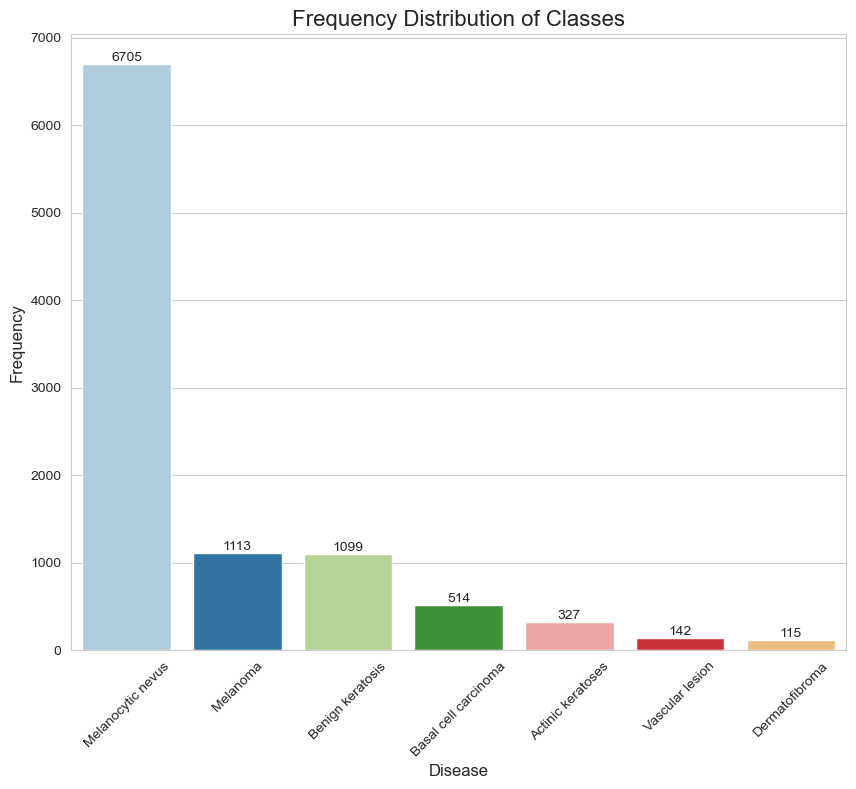

In [8]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x = 'disease', data = df, order = df['disease'].value_counts().index, palette='Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frequency Distribution of Classes', size=16)
plt.xticks(rotation=45)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.show()

In [9]:
def dataset_summary(class_counts):
    # Print the number of images in each class
    print("Dataset Summary")
    print("-" * 60)
    print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
    print("-" * 60)
    for class_label, class_name in lesion_type_dict.items():
        count = class_counts[class_name]
        print(f"{class_label:<15} {class_name:<30} {count:<10}")
    print("-" * 60)
    print(f"{'Total':<45} {sum(class_counts):<10}")

In [10]:
class_counts = df['disease'].value_counts()
dataset_summary(class_counts)

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
MEL             Melanoma                       1113      
NV              Melanocytic nevus              6705      
BCC             Basal cell carcinoma           514       
AKIEC           Actinic keratoses              327       
BKL             Benign keratosis               1099      
DF              Dermatofibroma                 115       
VASC            Vascular lesion                142       
------------------------------------------------------------
Total                                         10015     


In [11]:
image_size=224

In [12]:
max_workers = multiprocessing.cpu_count()

def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((image_size,image_size)))

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, (path + 'train/' + df['image'] + '.jpg').tolist()))

df['image_array'] = image_arrays
del image_arrays
df.head()

image  label            disease  \
0  ISIC_0024306      1  Melanocytic nevus   
1  ISIC_0024307      1  Melanocytic nevus   
2  ISIC_0024308      1  Melanocytic nevus   
3  ISIC_0024309      1  Melanocytic nevus   
4  ISIC_0024310      0           Melanoma   

                                         image_array  
0  [[[224, 129, 129], [226, 131, 132], [229, 131,...  
1  [[[215, 123, 134], [217, 123, 134], [218, 122,...  
2  [[[246, 172, 181], [247, 174, 181], [246, 172,...  
3  [[[208, 119, 134], [206, 120, 133], [207, 122,...  
4  [[[71, 34, 38], [72, 32, 39], [71, 32, 38], [6...

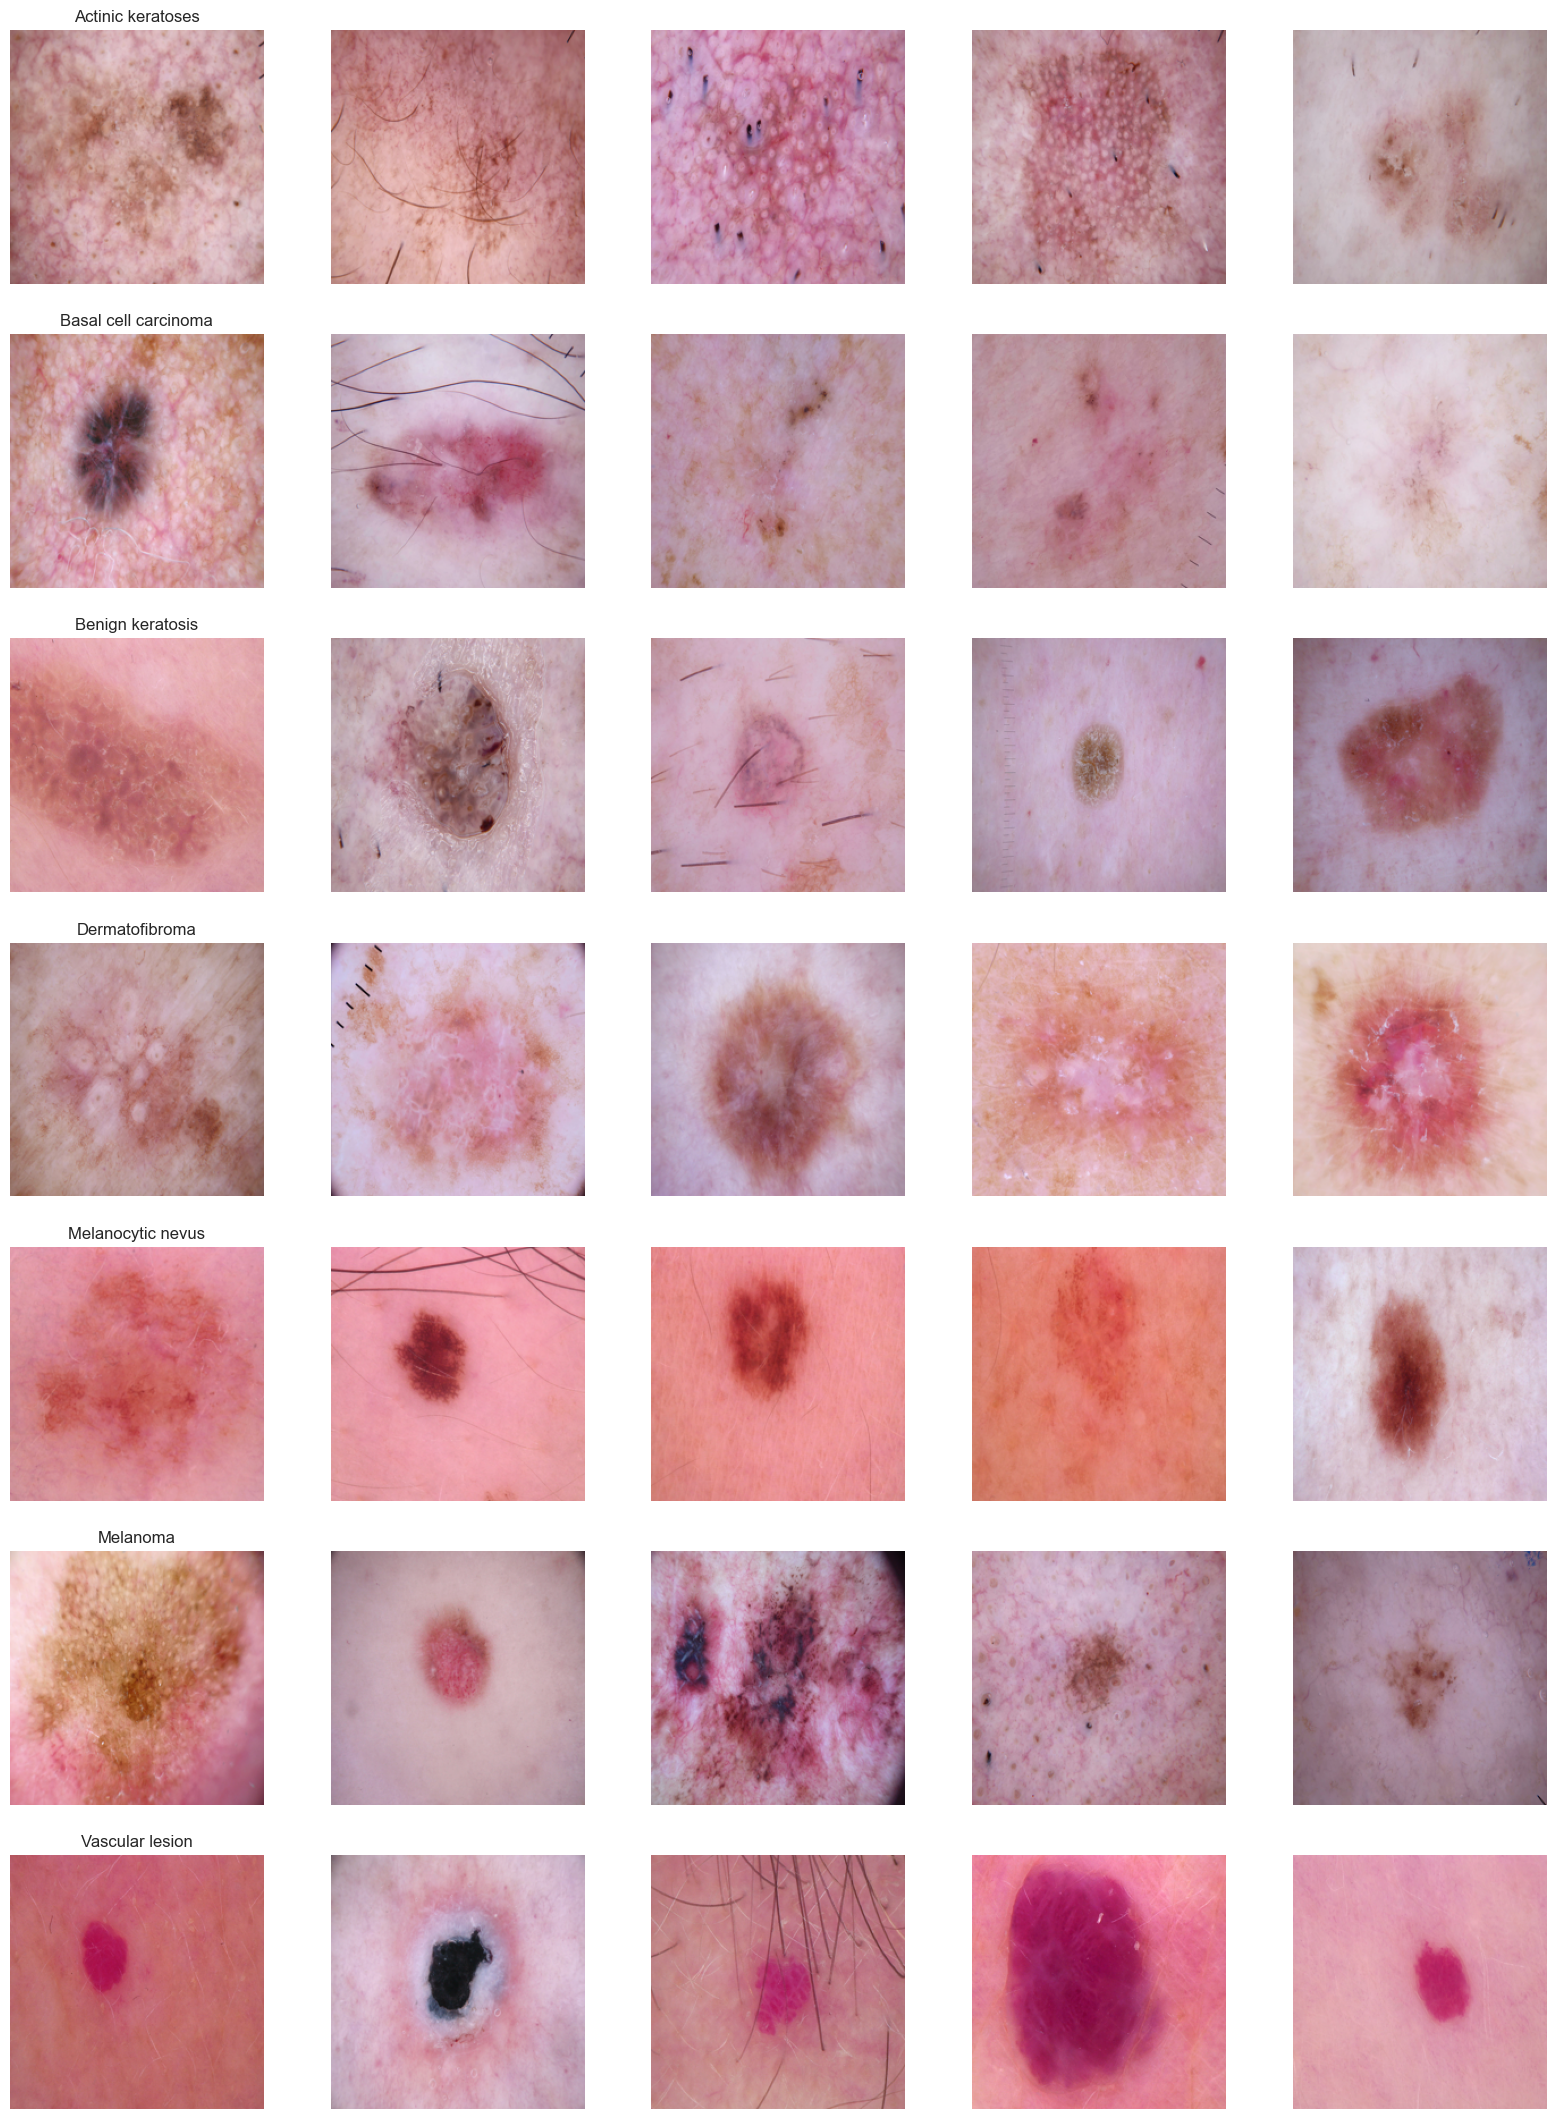

In [13]:
n_samples = 5
n_diseases = len(lesion_type_dict)
fig, m_axs = plt.subplots(n_diseases, n_samples, figsize = (4*n_samples, 3*9))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['disease']).groupby('disease')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=11223344).iterrows()):
        c_ax.imshow(c_row['image_array'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [14]:
X = df.drop(columns=['image','label','disease'],axis=1)
X = X['image_array'].to_list()
y = df['label'].to_list()

In [15]:
del df

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
del X
del y

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1111727505, random_state=42) # 80% 10% 10%

In [18]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [20]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))

In [21]:
np.save("x_train",x_train)
np.save("y_train", y_train)
np.save("x_val", x_val)
np.save("y_val", y_val)
np.save("x_test", x_test)
np.save("y_test", y_test)

In [24]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_val.shape, y_test.shape

((8010, 224, 224, 3),
 (1002, 224, 224, 3),
 (1003, 224, 224, 3),
 (8010, 7),
 (1003, 7),
 (1002, 7))

In [29]:
# Reset

In [5]:
x_train = np.load('x_train.npy')
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')

In [6]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_train, y_train, 8)
val_gen = DataGenerator(x_val, y_val, 8)

In [7]:
def build_model():
    baseModel = Xception(weights= 'imagenet', include_top = False, input_shape=(224, 224, 3))
    for layer in baseModel.layers:
        layer.trainable = True
    headModel = baseModel.output
    headModel = Flatten()(headModel)
    
    headModel = Dense(512)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(128)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(52)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(16,)(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Activation('relu')(headModel)
    
    headModel = Dense(len(lesion_type_dict), activation="softmax")(headModel)
    
    x = Model(baseModel.inputs,outputs=headModel)

    optimizers = Adam(learning_rate=  0.0001)
    x.compile(loss = 'categorical_crossentropy', optimizer = optimizers, metrics = ['accuracy'])
    return x

model= build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [8]:
history = model.fit(train_gen, validation_data = val_gen, epochs = 30)

Epoch 1/30
1002/1002 [==============================] - 168s 157ms/step - loss: 1.6836 - accuracy: 0.4272 - val_loss: 1.2815 - val_accuracy: 0.6191
Epoch 2/30
1002/1002 [==============================] - 157s 157ms/step - loss: 1.1396 - accuracy: 0.6708 - val_loss: 0.8767 - val_accuracy: 0.7478
Epoch 3/30
1002/1002 [==============================] - 158s 158ms/step - loss: 0.9168 - accuracy: 0.7252 - val_loss: 0.7948 - val_accuracy: 0.7507
Epoch 4/30
1002/1002 [==============================] - 158s 158ms/step - loss: 0.7889 - accuracy: 0.7533 - val_loss: 0.8047 - val_accuracy: 0.7388
Epoch 5/30
1002/1002 [==============================] - 160s 160ms/step - loss: 0.7131 - accuracy: 0.7709 - val_loss: 0.7421 - val_accuracy: 0.7507
Epoch 6/30
1002/1002 [==============================] - 165s 164ms/step - loss: 0.6455 - accuracy: 0.7914 - val_loss: 0.7138 - val_accuracy: 0.7577
Epoch 7/30
1002/1002 [==============================] - 166s 165ms/step - loss: 0.5821 - accuracy: 0.8197 - val_

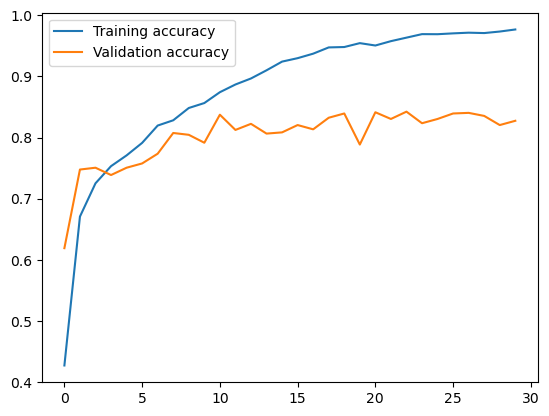

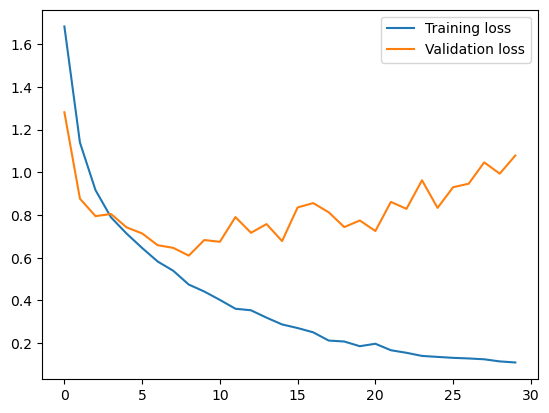

In [9]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

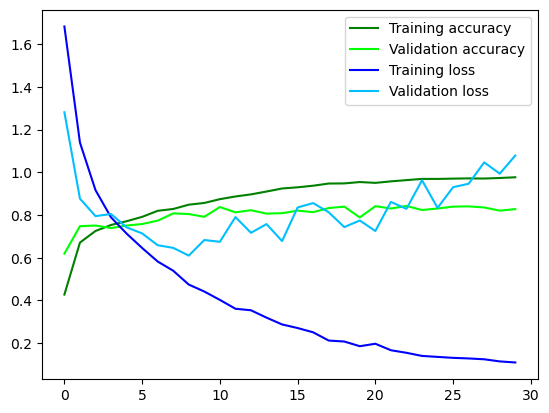

In [10]:
plt.plot(history.history['accuracy'], label='Training accuracy', color = "g")
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color = "lime")
plt.plot(history.history['loss'], label='Training loss', color = "b")
plt.plot(history.history['val_loss'], label='Validation loss', color = "deepskyblue")
plt.legend()
plt.show()

In [11]:
model.save('Xception_model_NA_Batch.h5')

C:\Users\Rayver\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [14]:
def get_svm_predictions(x_train_features, x_test_features, y_train, y_test):
    x_train_features  = x_train_features.reshape(x_train_features.shape[0], -1)
    x_test_features = x_test_features.reshape(x_test_features.shape[0], -1)

    clf = svm.SVC(kernel="rbf")
    clf.fit(x_train_features, np.argmax(y_train, axis=1))
    return clf.predict(x_test_features)

def plot_confusion_matrix(y_test, y_pred, cmap = plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=np.argmax(y_test, axis=1), cmap=cmap)
    plt.xticks(np.arange(len(classes)), lesion_type_dict, rotation=45)
    plt.yticks(np.arange(len(classes)), lesion_type_dict)
    plt.grid(False)
    plt.show()
    
def plot_classification_report(y_test, y_pred, target_names):
    print(classification_report(y_pred=y_pred, y_true= np.argmax(y_test, axis=1), target_names=target_names))

def create_and_plot_confusion_matrix(y_test, y_pred):
    def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        #plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, lesion_type_dict, rotation=45)
        plt.yticks(tick_marks, lesion_type_dict)

        if normalize:
            cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals = 2)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid(False)
        plt.show()
    cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    plot_cm(cm, normalize=False, classes = classes)
    
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

def print_multiclass_cm_metrics(y_test, y_pred, visualize = False, printable = True, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        if printable:
            print(f'Current Label: {lesion_type_dict[lesion_tag_dict[i]]}')
        if visualize:
            print(mcm[i])
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(classes))
    font_size=6
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        for x1, x2, x3, y1, y2, y3 in zip(x-width, x, x+width, precision, accuracy, sensitivity):
            plt.text(x1, y1, '%.2f' % y1, ha='center', va='bottom', fontsize=font_size)
            plt.text(x2, y2, '%.2f' % y2, ha='center', va='bottom', fontsize=font_size)
            plt.text(x3, y3, '%.2f' % y3, ha='center', va='bottom', fontsize=font_size)
        plt.xticks(x, lesion_type_dict)
        plt.legend(loc='lower left')
        plt.show()
def get_metrics(x, y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    plot_confusion_matrix(y_test=y, y_pred=y_pred)
    plot_classification_report(y_pred=y_pred, y_test=y, target_names=classes)
    print_multiclass_cm_metrics(y_test=y,y_pred=y_pred)

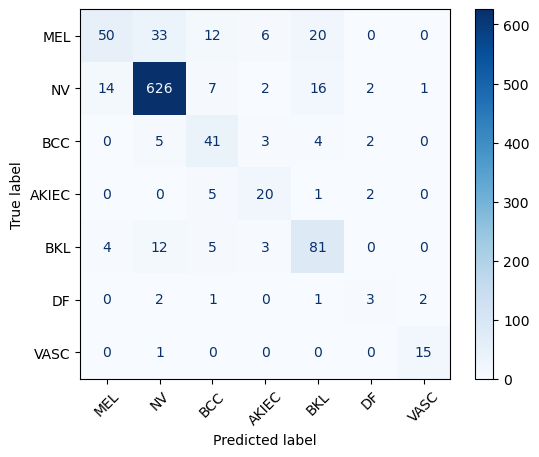

                      precision    recall  f1-score   support

            Melanoma       0.74      0.41      0.53       121
   Melanocytic nevus       0.92      0.94      0.93       668
Basal cell carcinoma       0.58      0.75      0.65        55
   Actinic keratoses       0.59      0.71      0.65        28
    Benign keratosis       0.66      0.77      0.71       105
      Dermatofibroma       0.33      0.33      0.33         9
     Vascular lesion       0.83      0.94      0.88        16

            accuracy                           0.83      1002
           macro avg       0.66      0.69      0.67      1002
        weighted avg       0.84      0.83      0.83      1002

Current Label: Melanoma
	Precision: 0.7352941176470589
	Sensitivity: 0.4132231404958678
	Specificity: 0.9795686719636776
	Accuracy: 0.9111776447105788

Current Label: Melanocytic nevus
	Precision: 0.9219440353460973
	Sensitivity: 0.937125748502994
	Specificity: 0.8413173652694611
	Accuracy: 0.9051896207584831

Cur

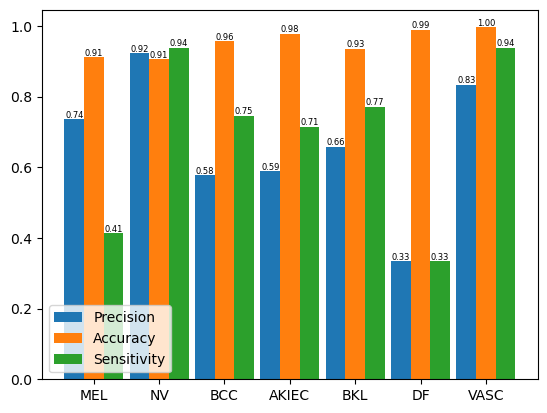

In [15]:
get_metrics(x_test, y_test)

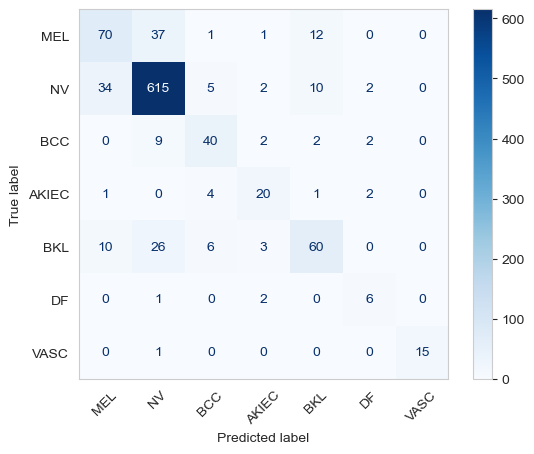

                      precision    recall  f1-score   support

            Melanoma       0.61      0.58      0.59       121
   Melanocytic nevus       0.89      0.92      0.91       668
Basal cell carcinoma       0.71      0.73      0.72        55
   Actinic keratoses       0.67      0.71      0.69        28
    Benign keratosis       0.71      0.57      0.63       105
      Dermatofibroma       0.50      0.67      0.57         9
     Vascular lesion       1.00      0.94      0.97        16

            accuracy                           0.82      1002
           macro avg       0.73      0.73      0.73      1002
        weighted avg       0.82      0.82      0.82      1002

Current Label: Melanoma
	Precision: 0.6086956521739131
	Sensitivity: 0.5785123966942148
	Specificity: 0.9489216799091941
	Accuracy: 0.9041916167664671

Current Label: Melanocytic nevus
	Precision: 0.8925979680696662
	Sensitivity: 0.9206586826347305
	Specificity: 0.7784431137724551
	Accuracy: 0.873253493013972

Cur

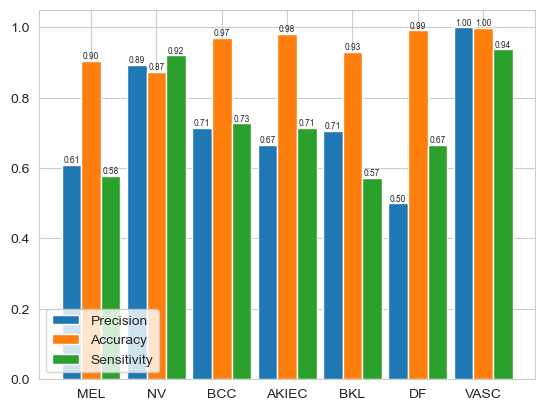

In [40]:
get_metrics(x_test, y_test)

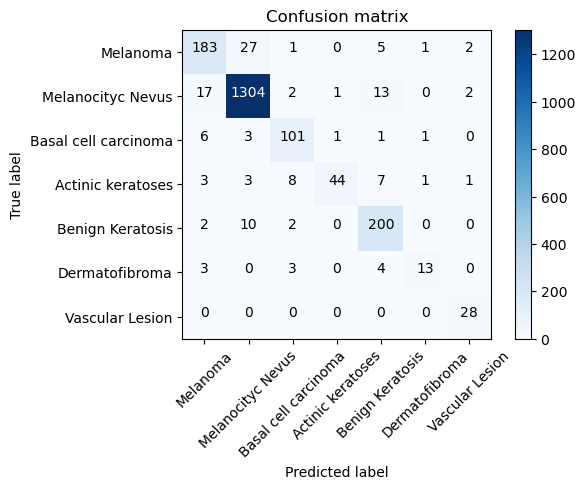

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals = 2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
classes = [lesion_type_dict[lesion_tag_dict[key]] for key in lesion_tag_dict]
plot_confusion_matrix(cm, normalize=False, classes = classes)
#cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.show(block=False)

In [25]:
print(classification_report(Y_true, Y_pred_classes, target_names=classes))

                      precision    recall  f1-score   support

            Melanoma       0.86      0.84      0.85       219
   Melanocityc Nevus       0.97      0.97      0.97      1339
Basal cell carcinoma       0.86      0.89      0.88       113
   Actinic keratoses       0.96      0.66      0.78        67
    Benign Keratosis       0.87      0.93      0.90       214
      Dermatofibroma       0.81      0.57      0.67        23
     Vascular Lesion       0.85      1.00      0.92        28

            accuracy                           0.94      2003
           macro avg       0.88      0.84      0.85      2003
        weighted avg       0.94      0.94      0.93      2003

